In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import copy 

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from ltn_imp.automation.knowledge_base import KnowledgeBase


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Train and Evaluate Models

In [ ]:
kb = KnowledgeBase("with_logic.yaml")

In [ ]:
device = torch.device("cpu")

def predict(model, x):
    try:
        model.eval()  # Ensure the model is in evaluation mode
    except:
        ""

    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()

        try:
            probs = model(x)
        except Exception as e:
            x = x.to(torch.device("cpu"))
            probs = torch.tensor(model.predict(x))

        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_metrics(model, data_loader):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

# Rule 1: (BMI > 29 and Glucose > 125) -> Diabetic (1)
def rule_1(data_df):
    condition = (data_df['BMI'] > 29) & (data_df['Glucose'] > 125)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Diabetic
    return outcome

# Rule 2: (BMI < 26 and Glucose < 101) -> Not Diabetic (0)
def rule_2(data_df):
    condition = (data_df['BMI'] < 26) & (data_df['Glucose'] < 101)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Not Diabetic
    return outcome

def rule_adherence(model, data_loader):

    adherence_scores = {f'Rule {i}': 0 for i in range(1, len(kb.rules) - 1)}
    total_relevant = {f'Rule {i}': 0 for i in range(1, len(kb.rules) - 1)}
    
    with torch.no_grad():
        for data, labels in data_loader:
            if isinstance(data, torch.Tensor):
                data = data.numpy()
            data_df = pd.DataFrame(data, columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                                                  'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
            
            preds = predict(model, data).squeeze().numpy()

            for i in range(1, len(kb.rules) - 1):
                rule_func = globals()[f'rule_{i}']
                expected_outcome = rule_func(data_df)

                relevant_indices = expected_outcome.notna()
                relevant_preds = preds[relevant_indices]
                relevant_expected = expected_outcome[relevant_indices]

                adherence = (relevant_expected == relevant_preds).astype(int)
                
                adherence_scores[f'Rule {i}'] += adherence.sum()
                total_relevant[f'Rule {i}'] += len(adherence)

    adherence_percentages = {rule: (adherence_scores[rule] / total_relevant[rule]) * 100 
                             for rule in adherence_scores}
    
    return adherence_percentages


In [ ]:
saved_models = []

for file_name in os.listdir("models"):
    if file_name.endswith('.pkl'):
        file_path = os.path.join("models", file_name)
        with open(file_path, 'rb') as file:
            trained_model = pickle.load(file)
            model_class = trained_model.__class__
            model_params = trained_model.get_params()
            new_model = model_class(**model_params)
            saved_models.append(new_model)

In [ ]:
def train(model, kb):

    criteria = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

    patience = 5
    min_delta = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(50):
        model.train()
        total_loss = 0.0
        num_batches = 0
        
        # Training loop
        for data, labels in kb.loaders[0]:
            optimizer.zero_grad()
            predictions = model(data)
            loss = criteria(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1

        avg_train_loss = total_loss / num_batches

        model.eval()
        total_val_loss = 0.0
        num_val_batches = 0

        for data, labels in kb.val_loaders[0]:
            with torch.no_grad():
                predictions = model(data)
                val_loss = criteria(predictions, labels)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches

        # Early stopping logic
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

        model.train()
    print()

In [ ]:
import torch.nn as nn

def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

    linear_layers = [module for module in model.modules() if isinstance(module, nn.Linear)]

    for layer in linear_layers[-2:]:
        for param in layer.parameters():
            param.requires_grad = True

In [ ]:
fine_tune = True

In [9]:
seeds = [random.randint(0, 1000) for _ in range(50)]

train_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])
test_df = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])

test_data = pd.read_csv('datasets/pima_indians_imputed.csv', index_col=0).astype(float)
y = test_data.iloc[:, -1]

adherence_df = pd.DataFrame(columns=["Rule " + str(i) for i in range(1, len(kb.rules) - 1)])

for seed in seeds:

    x_train, x_test = train_test_split(test_data, test_size=0.5, random_state=seed, stratify=y)
    y_train = x_train.iloc[:, -1]  # Extract labels from the training split
    x_train, x_val = train_test_split(x_train, test_size=0.1, random_state=seed, stratify=y_train)

    x_train.to_csv('datasets/train.csv')
    x_val.to_csv('datasets/val.csv')
    x_test.to_csv('datasets/test.csv')

    x_train, y_train = x_train.iloc[:, :-1], x_train.iloc[:, -1]
    x_test, y_test = x_test.iloc[:, :-1], x_test.iloc[:, -1]

    models = saved_models.copy()

    kb = KnowledgeBase("with_logic.yaml")

    models.append(kb.predicates["Diabetic"])

    X = kb.loaders[0].loader.dataset.data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin','BMI', 'DiabetesPedigreeFunction', 'Age']]
    Y = kb.loaders[0].loader.dataset.data['Outcome']

    for model in models:
        model_name = model.__class__.__name__

        if model_name == "Sequential":
            model_name = "SKI MLP" 
            
            if "Regular MLP" not in test_df.index:
                test_df.loc["Regular MLP"] = [[], [], [], [], [], []]
                adherence_df.loc["Regular MLP"] = [[] for _ in range(1, len(kb.rules) - 1)] 

        if model_name not in test_df.index:
            test_df.loc[model_name] = [[], [], [], [], [], []]
            adherence_df.loc[model_name] = [ [] for _ in range(1, len(kb.rules) - 1)] 

        if hasattr(model, "fit"):
            model.fit(X, Y)

        elif model_name == "SKI MLP":

            if fine_tune:
                train(model, kb)
                freeze_model(model)
                accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
            else:
                model_ = copy.deepcopy(model)
                train(model_, kb)
                accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model_, kb.test_loaders[0])

            test_df.loc["Regular MLP", "Accuracy"].append(accuracy)
            test_df.loc["Regular MLP", "Precision"].append(precision)
            test_df.loc["Regular MLP", "Recall"].append(recall)
            test_df.loc["Regular MLP", "F1 Score"].append(f1)
            test_df.loc["Regular MLP", "Balanced Accuracy"].append(balanced_accuracy)
            test_df.loc["Regular MLP", "MCC"].append(mcc)    

            adherence = rule_adherence(model, kb.test_loaders[0])
            for rule in adherence:
                adherence_df.loc["Regular MLP", rule].append(adherence[rule])
            
            if fine_tune:
                kb.optimize(num_epochs=200, lr=0.000001, early_stopping=True, verbose=False)
            else:
                kb.optimize(num_epochs=100, lr=0.00001, early_stopping=True, verbose=False)

        accuracy, precision, recall, f1, balanced_accuracy, mcc = compute_metrics(model, kb.test_loaders[0])
        test_df.loc[model_name, "Accuracy"].append(accuracy)
        test_df.loc[model_name, "Precision"].append(precision)
        test_df.loc[model_name, "Recall"].append(recall)
        test_df.loc[model_name, "F1 Score"].append(f1)
        test_df.loc[model_name, "Balanced Accuracy"].append(balanced_accuracy)
        test_df.loc[model_name, "MCC"].append(mcc)        

        adherence = rule_adherence(model, kb.test_loaders[0])
        for rule in adherence:
            adherence_df.loc[model_name, rule].append(adherence[rule])

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu

Using device: cpu



# Performance Evaluation

In [10]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [11]:
import scipy.stats as stats

def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        try:
            mean_scores = metrics_df[metric].apply(np.mean)
            best_model = mean_scores.idxmax()  
            best_models[metric] = best_model
        except:
            print(f"Rule {metric} not available")
            continue

    results = {}
    for metric in metrics_df.columns:
        try:   
            best_model = best_models[metric]
            best_scores = metrics_df.loc[best_model, metric]
            
            results[metric] = {}
            
            for model_name in metrics_df.index:
                if model_name == best_model:
                    continue
                
                comparison_scores = metrics_df.loc[model_name, metric]
                t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
                results[metric][model_name] = p_value 

        except:
            print(f"Rule {metric} not available")
            continue

    significance_level = 0.05
    for metric, comparisons in results.items():
        try:
            print(f"\n{metric}:")
            best_model = best_models[metric]
            for model_name, p_value in comparisons.items():
                if p_value < significance_level:
                    print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [12]:
def perform_t_tests(metrics_df, model_name):
    results = {}

    for metric in metrics_df.columns:

        if model_name == "SKI MLP":
            continue
        
        # Retrieve the scores for SKI MLP and Regular MLP
        ski_mlp_scores = np.array(metrics_df.loc['SKI MLP', metric])
        regular_mlp_scores = np.array(metrics_df.loc[model_name, metric])
        
        # Perform a paired t-test between SKI MLP and Regular MLP
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        # Calculate the mean difference
        mean_difference = np.mean(ski_mlp_scores - regular_mlp_scores)
        
        results[metric] = {'p_value': p_value, 'mean_difference': mean_difference}

    # Significance level for the tests
    significance_level = 0.05

    for metric, result in results.items():
        try:
            p_value = result['p_value']
            mean_difference = result['mean_difference']
            
            print(f"\n{metric}:")
            if p_value < significance_level:
                if mean_difference > 0:
                    print(f"  SKI MLP is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {model_name} is significantly better than SKI MLP (p = {p_value:.4f})")
            else:
                print(f"  There is no significant difference between SKI MLP and {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

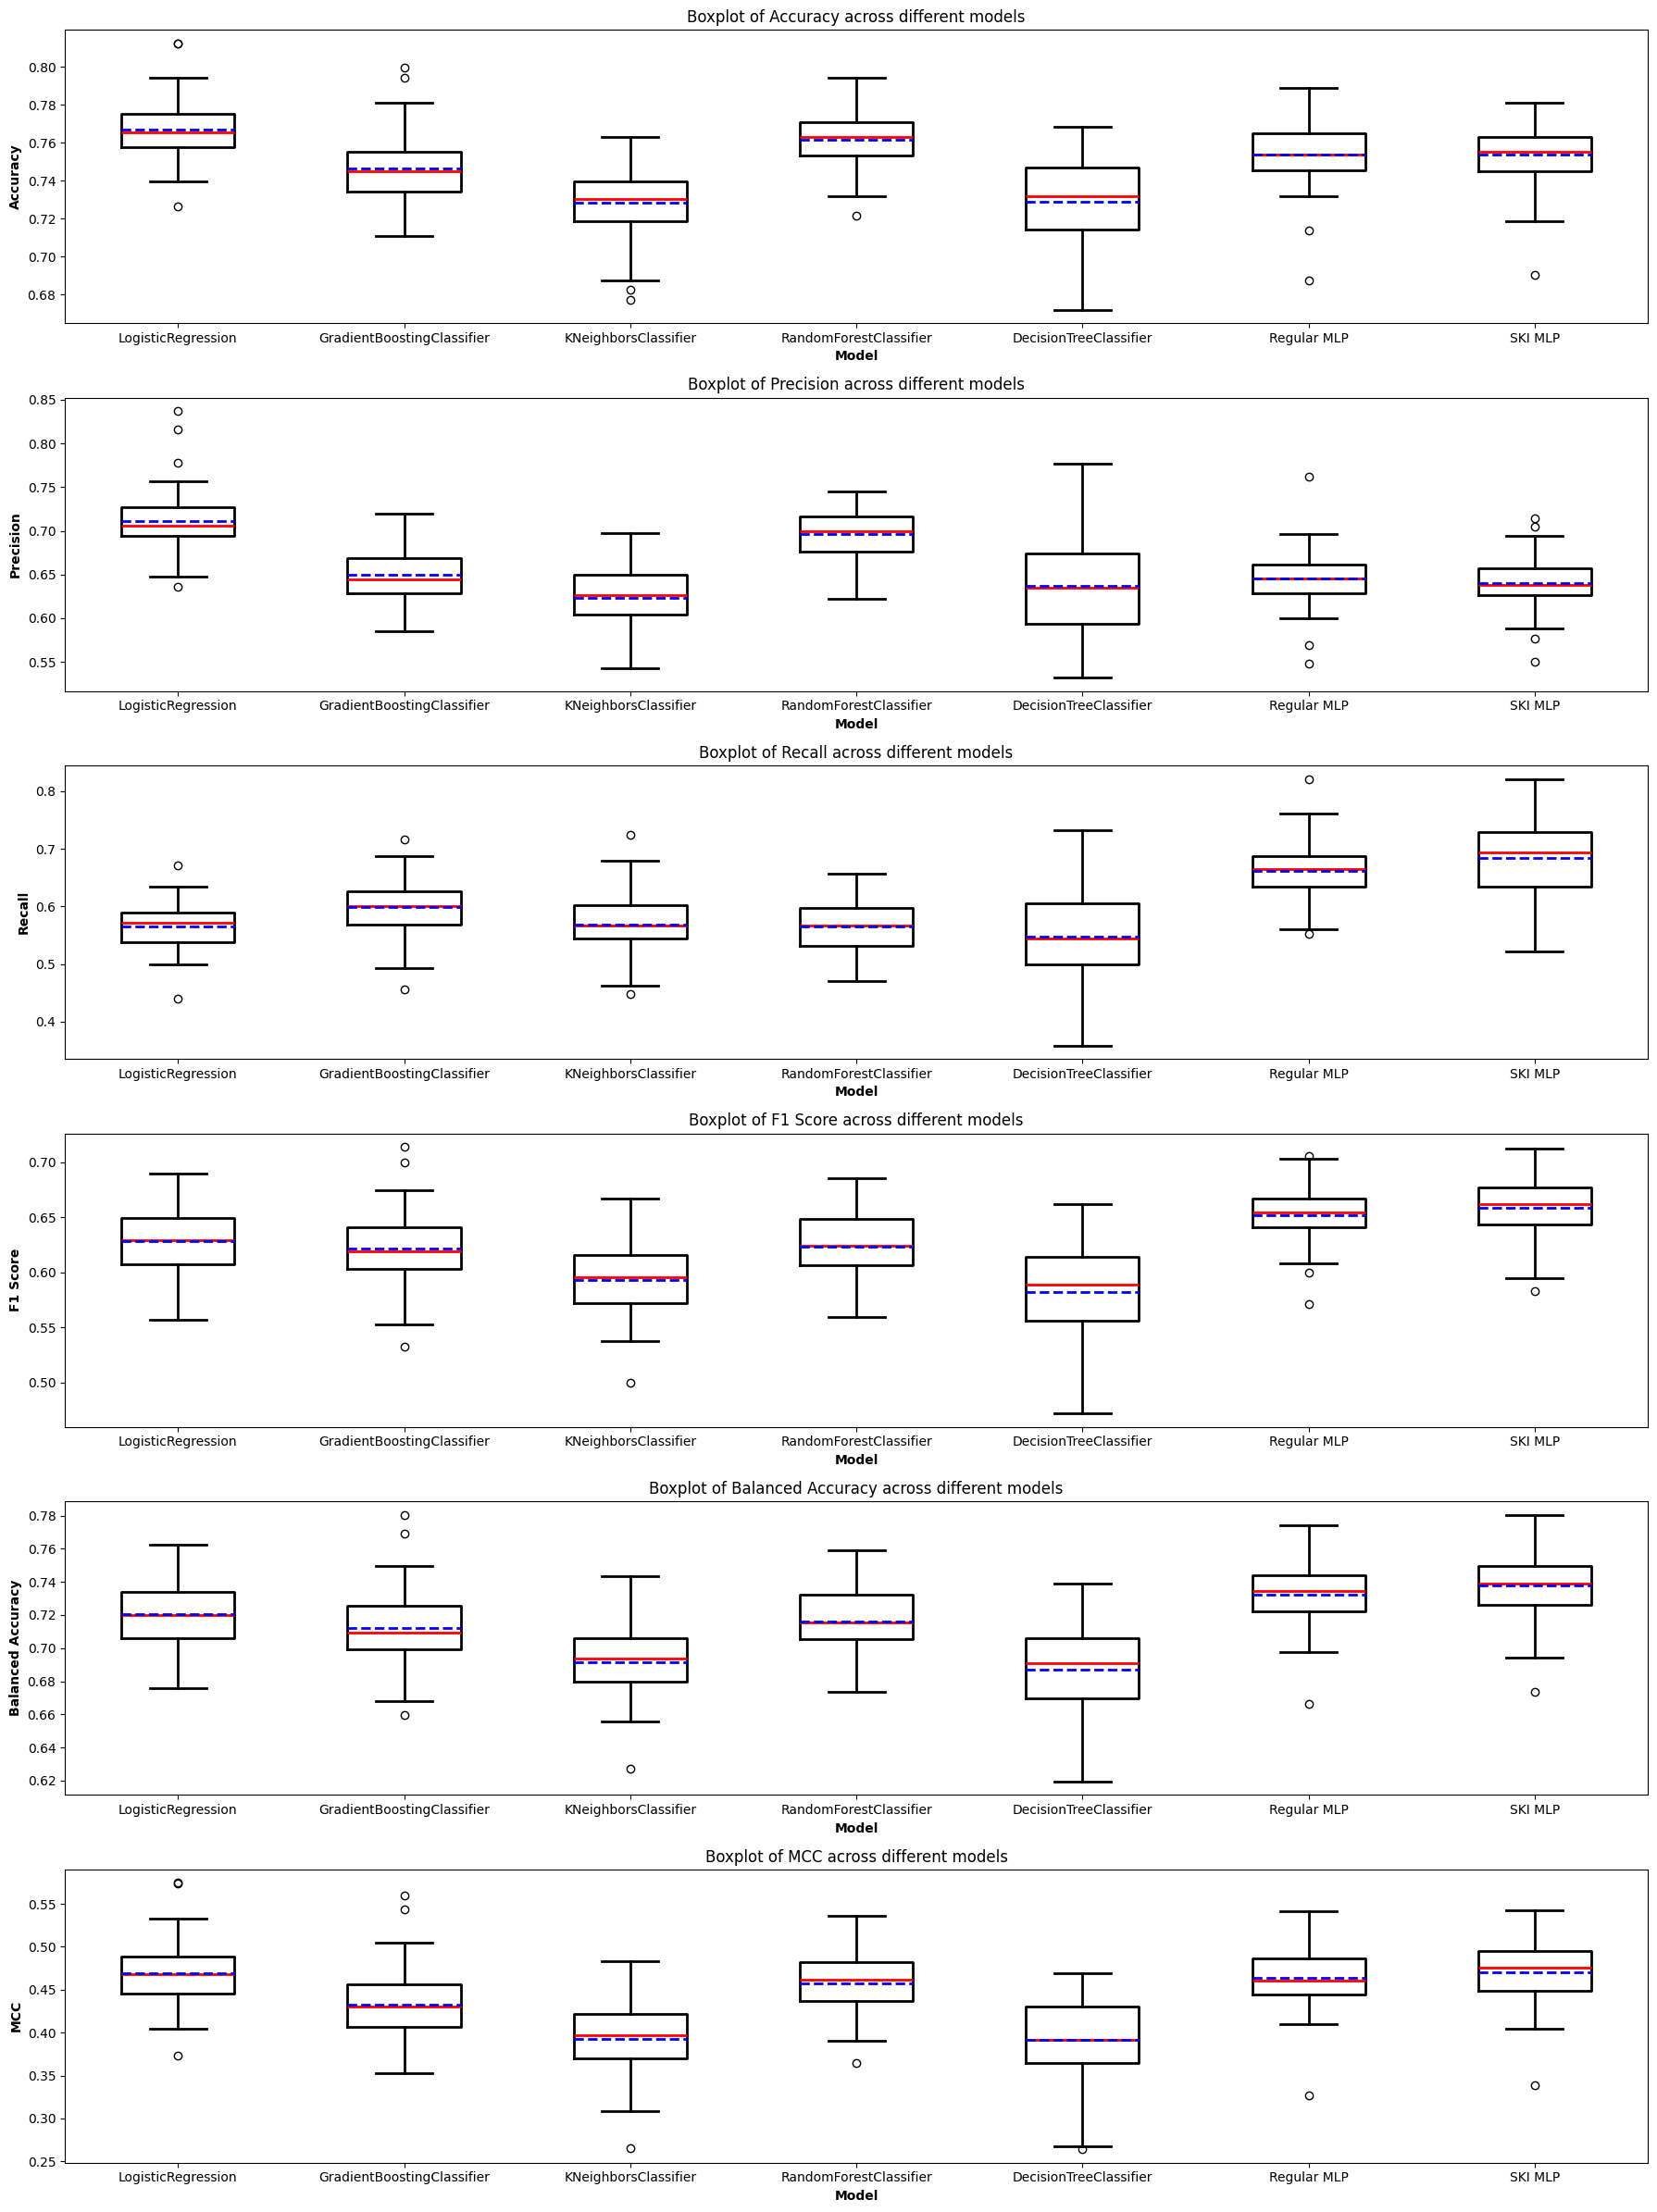

In [13]:
plot_metrics(test_df, ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"])

In [14]:
compare_models(test_df)


Accuracy:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0088)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0.0000)
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)

Precision:
  LogisticRegression is significantly better than GradientBoostingClassifier (p = 0.0000)
  LogisticRegression is significantly better than KNeighborsClassifier (p = 0.0000)
  LogisticRegression is significantly better than RandomForestClassifier (p = 0.0010)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0000)
  LogisticRegression is significantly better than Regular MLP (p = 0.0000)
  LogisticRegression is significantly better than SKI MLP (p = 0

In [15]:
for model in test_df.index:
    perform_t_tests(test_df, model)
    print()
    print( "-" * 100)


Accuracy:
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)

Precision:
  LogisticRegression is significantly better than SKI MLP (p = 0.0000)

Recall:
  SKI MLP is significantly better than LogisticRegression (p = 0.0000)

F1 Score:
  SKI MLP is significantly better than LogisticRegression (p = 0.0000)

Balanced Accuracy:
  SKI MLP is significantly better than LogisticRegression (p = 0.0000)

MCC:
  There is no significant difference between SKI MLP and LogisticRegression (p = 0.8939)

----------------------------------------------------------------------------------------------------

Accuracy:
  SKI MLP is significantly better than GradientBoostingClassifier (p = 0.0021)

Precision:
  GradientBoostingClassifier is significantly better than SKI MLP (p = 0.0430)

Recall:
  SKI MLP is significantly better than GradientBoostingClassifier (p = 0.0000)

F1 Score:
  SKI MLP is significantly better than GradientBoostingClassifier (p = 0.0000)

Balanced Accuracy:
  SKI 

# Logic Adherence

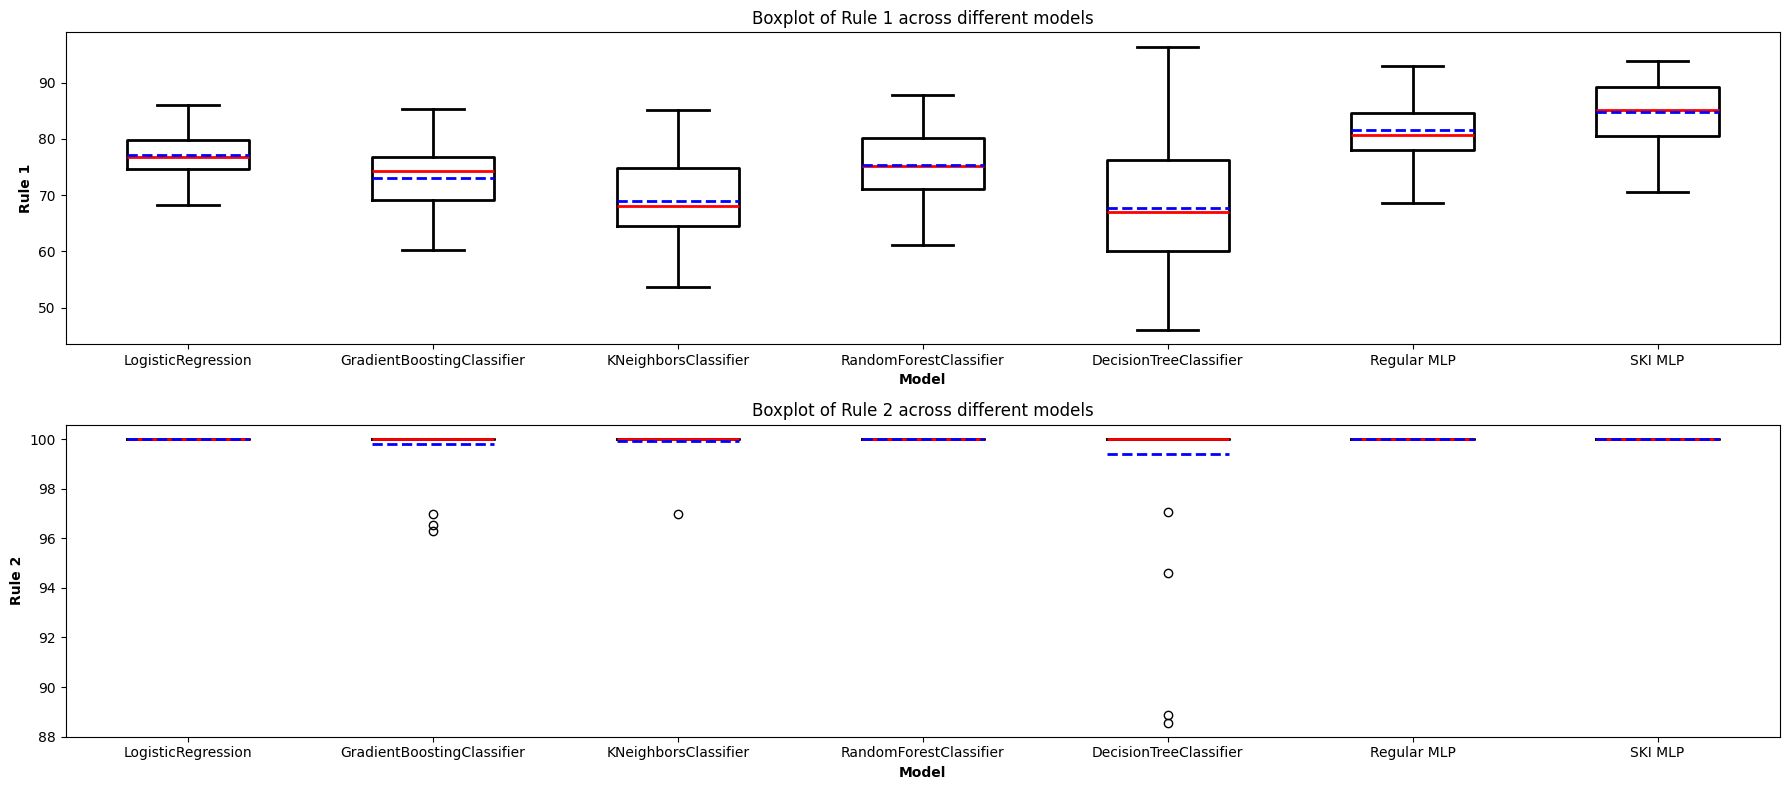

In [16]:
plot_metrics( adherence_df, ["Rule " + str(i) for i in range(1, len(kb.rules) - 1)])

In [17]:
compare_models(adherence_df)


Rule 1:
  SKI MLP is significantly better than LogisticRegression (p = 0.0000)
  SKI MLP is significantly better than GradientBoostingClassifier (p = 0.0000)
  SKI MLP is significantly better than KNeighborsClassifier (p = 0.0000)
  SKI MLP is significantly better than RandomForestClassifier (p = 0.0000)
  SKI MLP is significantly better than DecisionTreeClassifier (p = 0.0000)
  SKI MLP is significantly better than Regular MLP (p = 0.0002)

Rule 2:
  LogisticRegression is NOT significantly better than GradientBoostingClassifier (p = 0.0843)
  LogisticRegression is NOT significantly better than KNeighborsClassifier (p = 0.3222)
  LogisticRegression is NOT significantly better than RandomForestClassifier (p = nan)
  LogisticRegression is NOT significantly better than DecisionTreeClassifier (p = 0.0702)
  LogisticRegression is NOT significantly better than Regular MLP (p = nan)
  LogisticRegression is NOT significantly better than SKI MLP (p = nan)


In [18]:
for model in test_df.index:
    perform_t_tests(adherence_df, model)
    print()
    print( "-" * 100)


Rule 1:
  SKI MLP is significantly better than LogisticRegression (p = 0.0000)

Rule 2:
  There is no significant difference between SKI MLP and LogisticRegression (p = nan)

----------------------------------------------------------------------------------------------------

Rule 1:
  SKI MLP is significantly better than GradientBoostingClassifier (p = 0.0000)

Rule 2:
  There is no significant difference between SKI MLP and GradientBoostingClassifier (p = 0.0843)

----------------------------------------------------------------------------------------------------

Rule 1:
  SKI MLP is significantly better than KNeighborsClassifier (p = 0.0000)

Rule 2:
  There is no significant difference between SKI MLP and KNeighborsClassifier (p = 0.3222)

----------------------------------------------------------------------------------------------------

Rule 1:
  SKI MLP is significantly better than RandomForestClassifier (p = 0.0000)

Rule 2:
  There is no significant difference between SKI M